Disease Spread over a Network
===

##The Data

The dataset used by this model comes from a weighted-graph algorithm that dictates the evolution of the spread of a disease over a network of $n$ nodes. An edge between node $i$ and node $j$ has an assigned score of how likely it is for infected node $i$ to pass the disease to node $j$ or viceversa. The spread evolves over $T$ timesteps, where each timestep $t$ corresponds to a snapshot of the network after one day. There are $m$ different experiments of $T$ timesteps, in which at $t=0$ some few nodes are infected. Each node $i$ has an assigned number $p_i(t)\in[0,1]$ that represents the probability of having acquired the disease after $t$ timesteps. The scores of the edges do not evolve overtime and are the same for each experiment. What changes from experiment to experiment is what nodes are initially infected. In our dataset $m=4000$, $T=21$, and $n=100$.

##The Problem

The goal of the model is, given an initial state of the network with some infected nodes $\{ j\subseteq[n] : p_j(0)=1\}$, predict the evolution of the probabilities $\{p_i(t)\}_{i\neq j\in[n]}$ for $t=1,\dots, T$, without any knowledge of the scores, or any information about the network's connectivity. We would like to build a model that can predict the evolution of the probabilities $p_i(t)$ by hiding the causal factors of the evolution and showing to it only the actual evolutions. 

##The model

Let $p^{(k)}_i(t)$ denote the probability that node $i$ has acquired the disease after $t$ timesteps in the $k$-th experiment, and let $$\overrightarrow{p}^{(k)}(t)= [p^{(k)}_0(t) \,\, p^{(k)}_2(t) \,\, \dots \,\, p^{(k)}_n(t)] .$$ One one to frame our problem is to aim to model the conditional probability of predicting a certain $\overrightarrow{p}^{(k)}(t+1)$ given $\overrightarrow{p}^{(k)}(t), \dots, \overrightarrow{p}^{(k)}(0)$. Due to the evolutive nature of the problem, implementing an LSTM neural network seems natural. 

Our LSTMs will ingest a matrix $$x^{(k)} = [\overrightarrow{p}^{(k)}(0), \,\, \overrightarrow{p}^{(k)}(1), \, \dots, \,\overrightarrow{p}^{(k)}(T-1)] $$ and compare its output, a prediction $\hat{y}^{(k)}$, with the ground truth $$y^{(k)} = [\overrightarrow{p}^{(k)}(1), \,\, \overrightarrow{p}^{(k)}(2), \, \dots, \,\overrightarrow{p}^{(k)}(T)] $$ through a loss function. Then we will proceed to minimize that loss function with respect to the shared parameteres of the LSTMs to push $\hat{y}^{(k)}$ closer to $y^{(k)}$. We will refer to a tuple $(x^{(k)}, y^{(k)})$ as the $k$-th training examples. The dataset then consists of the tensors $X = [x^{(0)} \, \dots \, x^{(m)}]$, $Y = [y^{(0)} \, \dots \, y^{(m)}]$ containing all $m$ training examples.

In [1]:
#import dependencies and check for availability of a gpu

import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os

print(f'PyTorch version: {torch.__version__}')

if torch.cuda.is_available()==True:
    use_cuda = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')

PyTorch version: 1.3.1
GPU available: Tesla P100-PCIE-16GB (1 count)


In [0]:
#if there is a gpu available set it as the default device

def default_device():
    if torch.cuda.is_available()==True:
        dflt_device = torch.device('cuda')
    else:
        dflt_device = torch.device('cpu')

    return dflt_device

dflt_device = default_device()

In [0]:
#loads the dataset as a torch tensor, and create X, Y, and a test set
def create_dataset(dir_in_str, dflt_device, testset_size=200):
    dataset_np = np.load(dir_in_str)
    dataset_py = torch.from_numpy(dataset_np).transpose(1,0)
    X_train = Variable(dataset_py[:-testset_size,0:-1,:]).to(device=dflt_device)
    Y_train = Variable(dataset_py[:-testset_size,1:,:]).to(device=dflt_device)
    dataset_test = Variable(dataset_py[-testset_size:,:,:]).to(device=dflt_device)
    
    return X_train, Y_train, dataset_test

#creates the LSTM module connected to a linear layer
class Net(torch.nn.Module):
    def __init__(self, lstm_input_size, lstm_hidden_size, linear_output_size, num_lstm_layers):
        super(Net, self).__init__()
        self.lstm_input_size     = lstm_input_size
        self.lstm_hidden_size    = lstm_hidden_size
        self.linear_output_size  = linear_output_size
        self.num_lstm_layers     = num_lstm_layers
        
        self.lstm   = torch.nn.LSTM(self.lstm_input_size, self.lstm_hidden_size, \
                                    self.num_lstm_layers, batch_first=True, bidirectional=False)
        self.linear = torch.nn.Linear(self.lstm_hidden_size, self.linear_output_size)
        
        
    def forward(self, lstm_input, prev_hidden):
        lstm_output, lstm_hidden = self.lstm(lstm_input, prev_hidden)
        linear_output = self.linear(lstm_output)
        
        return linear_output, lstm_hidden
    
#it predicts the evolution of all the p_i's through a \
#given number of timesteps given an initial state of p_i's
def predict_seq(x, timesteps):
    numNodes     = x.size(0)
    Y_pred       = torch.zeros(timesteps, numNodes).to(device=dflt_device)
    Y_pred[0, :] = x.view(1, numNodes)
    prev_hidden  = (torch.zeros(num_lstm_layers, 1, lstm_hidden_size).to(device=dflt_device),\
              torch.zeros(num_lstm_layers, 1, lstm_hidden_size).to(device=dflt_device) )
    
    x_ini   = x.view(1, 1, -1)
    mask_py = torch.ones(x.shape).to(device=dflt_device)
    x_prev  = x_ini
    for step in range(1, timesteps):
        x_next, next_hidden = forward_pass(x_prev, prev_hidden)
        x_next = torch.min(x_next + x_ini, mask_py)
        Y_pred[step,:] = x_next.view(1, numNodes)
        x_prev = x_next
        prev_hidden = next_hidden

    Y_pred   = Y_pred.cpu()    
    Y_pred   = Y_pred.detach().numpy()
    mask_np  = np.ones(Y_pred.shape)
    masked_Y = np.minimum(Y_pred, mask_np)
    
    return masked_Y


#calculates the prediction error on the test set
def test_set_error(dataset_test):
    num_examples = dataset_test.shape[0]
    cumulative_error = 0
    for example_idx in range(num_examples):
        Y_true = dataset_test[example_idx, :, :].detach().cpu()
        Y_true = Y_true.detach().numpy()
        num_timesteps = Y_true.shape[0]
        Y_pred = predict_seq(dataset_test[example_idx,0,:], num_timesteps)
        #bin_idxs = Y_pred[0,:].shape[0]
        for day in range(num_timesteps):
            error = np.sum(np.abs(Y_true[day,:] - Y_pred[day,:]))*100/num_nodes
            cumulative_error += error/num_timesteps
    average_error = cumulative_error/num_examples
    print(f'Average error on the test set: {round(average_error, 2)} %')


#compares the prediction and ground truth using bar plots
def compare_bars(dataset_test, example_num):   
    Y_true = dataset_test[example_num, :, :].detach().cpu()
    Y_true = Y_true.detach().numpy()
    num_timesteps = Y_true.shape[0]
    Y_pred = predict_seq(dataset_test[example_num,0,:], num_timesteps)
    bin_idxs = Y_pred[0,:].shape[0]
    cumulative_error = 0
    for day in range(num_timesteps):
        plt.figure(figsize=(10,10))
        plt.bar(np.arange(bin_idxs), height=Y_pred[day,:], alpha=0.9, color='yellow', label='Predicted')
        plt.bar(np.arange(bin_idxs), height=Y_true[day,:], alpha=0.4, color='blue', label='True')
        plt.legend(loc='best')
        plt.show()
        error = np.sum(np.abs(Y_true[day,:] - Y_pred[day,:]))*100/num_nodes
        cumulative_error += error
        if day==0:
          print(f'Initial infected nodes')
        if day>0:
          print(f'Error from day {day} to day {day+1}: {round(error, 2)} %')

    print('----------------------------------------------------------------------------')
    print(f'Average error day by day: { round(cumulative_error/(num_timesteps-1), 2) } %')


#compares the curve plots of the prediction and ground truth
def compare_curves(dataset_test, example_num):
    Y_true = dataset_test[example_num, :, :].detach().cpu()
    Y_true = Y_true.detach().numpy()
    num_timesteps = Y_true.shape[0]
    Y_pred = predict_seq(dataset_test[example_num,0,:], num_timesteps)
    bin_idxs = Y_pred[0,:].shape[0]

    dt=1/20
    t=np.arange(0,1+dt,dt)

    fig=plt.figure(figsize=(30,30))
    for i in range(100):
      true_p = Y_true[:,i]
      pred_p = Y_pred[:,i]
      plt.ylim(-0.05, 1.05)
      plt.subplot(10,10,(i+1))
      plt.plot(t, true_p, label='True')
      plt.plot(t, pred_p, label='Predicted')
      plt.legend(loc='best')
      plt.yscale('linear')    
      plt.title(f'p^({example_num})_{i}')
      plt.grid(True)



In [0]:
#load the dataset and test set, choose the size of the data set
testSetSize = 100
X_train, Y_train, dataset_test = create_dataset('Train.npy', dflt_device, testset_size=testSetSize)

In [5]:
torch.manual_seed(12)

#dimensions of the dataset
num_examples, num_timesteps, num_nodes = X_train.size()

#specify the dimentsions of the LSTM
num_lstm_layers  = 1
lstm_hidden_size = 256

#specify the training parameters
LR          = 0.005
epochs      = 15000
WeightDecay = 1e-8
Momentum    = 0.9

#create the forward pass and initial hidden state
forward_pass = Net(num_nodes, lstm_hidden_size, num_nodes, num_lstm_layers)
forward_pass = forward_pass.to(device=dflt_device)
initHidden   = (torch.zeros(num_lstm_layers, num_examples, lstm_hidden_size).to(device=dflt_device),\
                torch.zeros(num_lstm_layers, num_examples, lstm_hidden_size).to(device=dflt_device) )

#define the loss function, optimizer, and learning rate scheduler
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(forward_pass.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-8, weight_decay = WeightDecay )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.000001, last_epoch=-1)

#count the number of trainable parameters
num_parameters = sum([p.numel() for p in forward_pass.parameters()])
print(f'Number of training examples: {num_examples}')
print(f'Number of trainable parameters: {num_parameters}')

Number of training examples: 3900
Number of trainable parameters: 392292


Epoch: 50, Loss: 0.013551853597164154  (Learning rate: [0.004999862950829098])
Epoch: 100, Loss: 0.012696689926087856  (Learning rate: [0.004999451818345376])
Epoch: 150, Loss: 0.011410119943320751  (Learning rate: [0.004998766647634146])
Epoch: 200, Loss: 0.009528842754662037  (Learning rate: [0.004997807513832097])
Epoch: 250, Loss: 0.006935972720384598  (Learning rate: [0.004996574522119057])
Epoch: 300, Loss: 0.004598254803568125  (Learning rate: [0.004995067807706465])
Epoch: 350, Loss: 0.003077172441408038  (Learning rate: [0.004993287535822533])
Epoch: 400, Loss: 0.002170602325350046  (Learning rate: [0.004991233901694136])
Epoch: 450, Loss: 0.0018150759860873222  (Learning rate: [0.0049889071305253985])
Epoch: 500, Loss: 0.001410146476700902  (Learning rate: [0.004986307477472999])
Epoch: 550, Loss: 0.001191801973618567  (Learning rate: [0.00498343522761819])
Epoch: 600, Loss: 0.001004628837108612  (Learning rate: [0.0049802906959355376])
Epoch: 650, Loss: 0.0009651446016505361

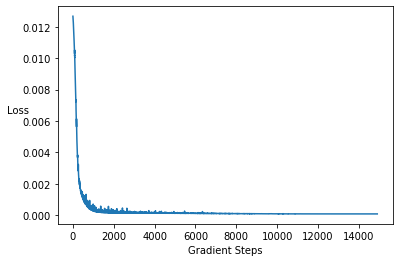

In [6]:
#train the parameters
loss_hist  = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    Y_hat, _ = forward_pass(X_train, initHidden)
    Loss = loss_func(Y_hat,Y_train)
    Loss.backward()
    optimizer.step()
    loss_hist.append(Loss.item())
    scheduler.step()
    if epoch%50==0:
      print(f'Epoch: {epoch}, Loss: {Loss}  (Learning rate: {scheduler.get_lr()})')
    
plt.plot(loss_hist[100:])
plt.xlabel('Gradient Steps')
vert_label=plt.ylabel('Loss')
vert_label.set_rotation(0)

In [7]:
#calculate the average prediction error over the test set
test_set_error(dataset_test)

Average error on the test set: 2.7 %


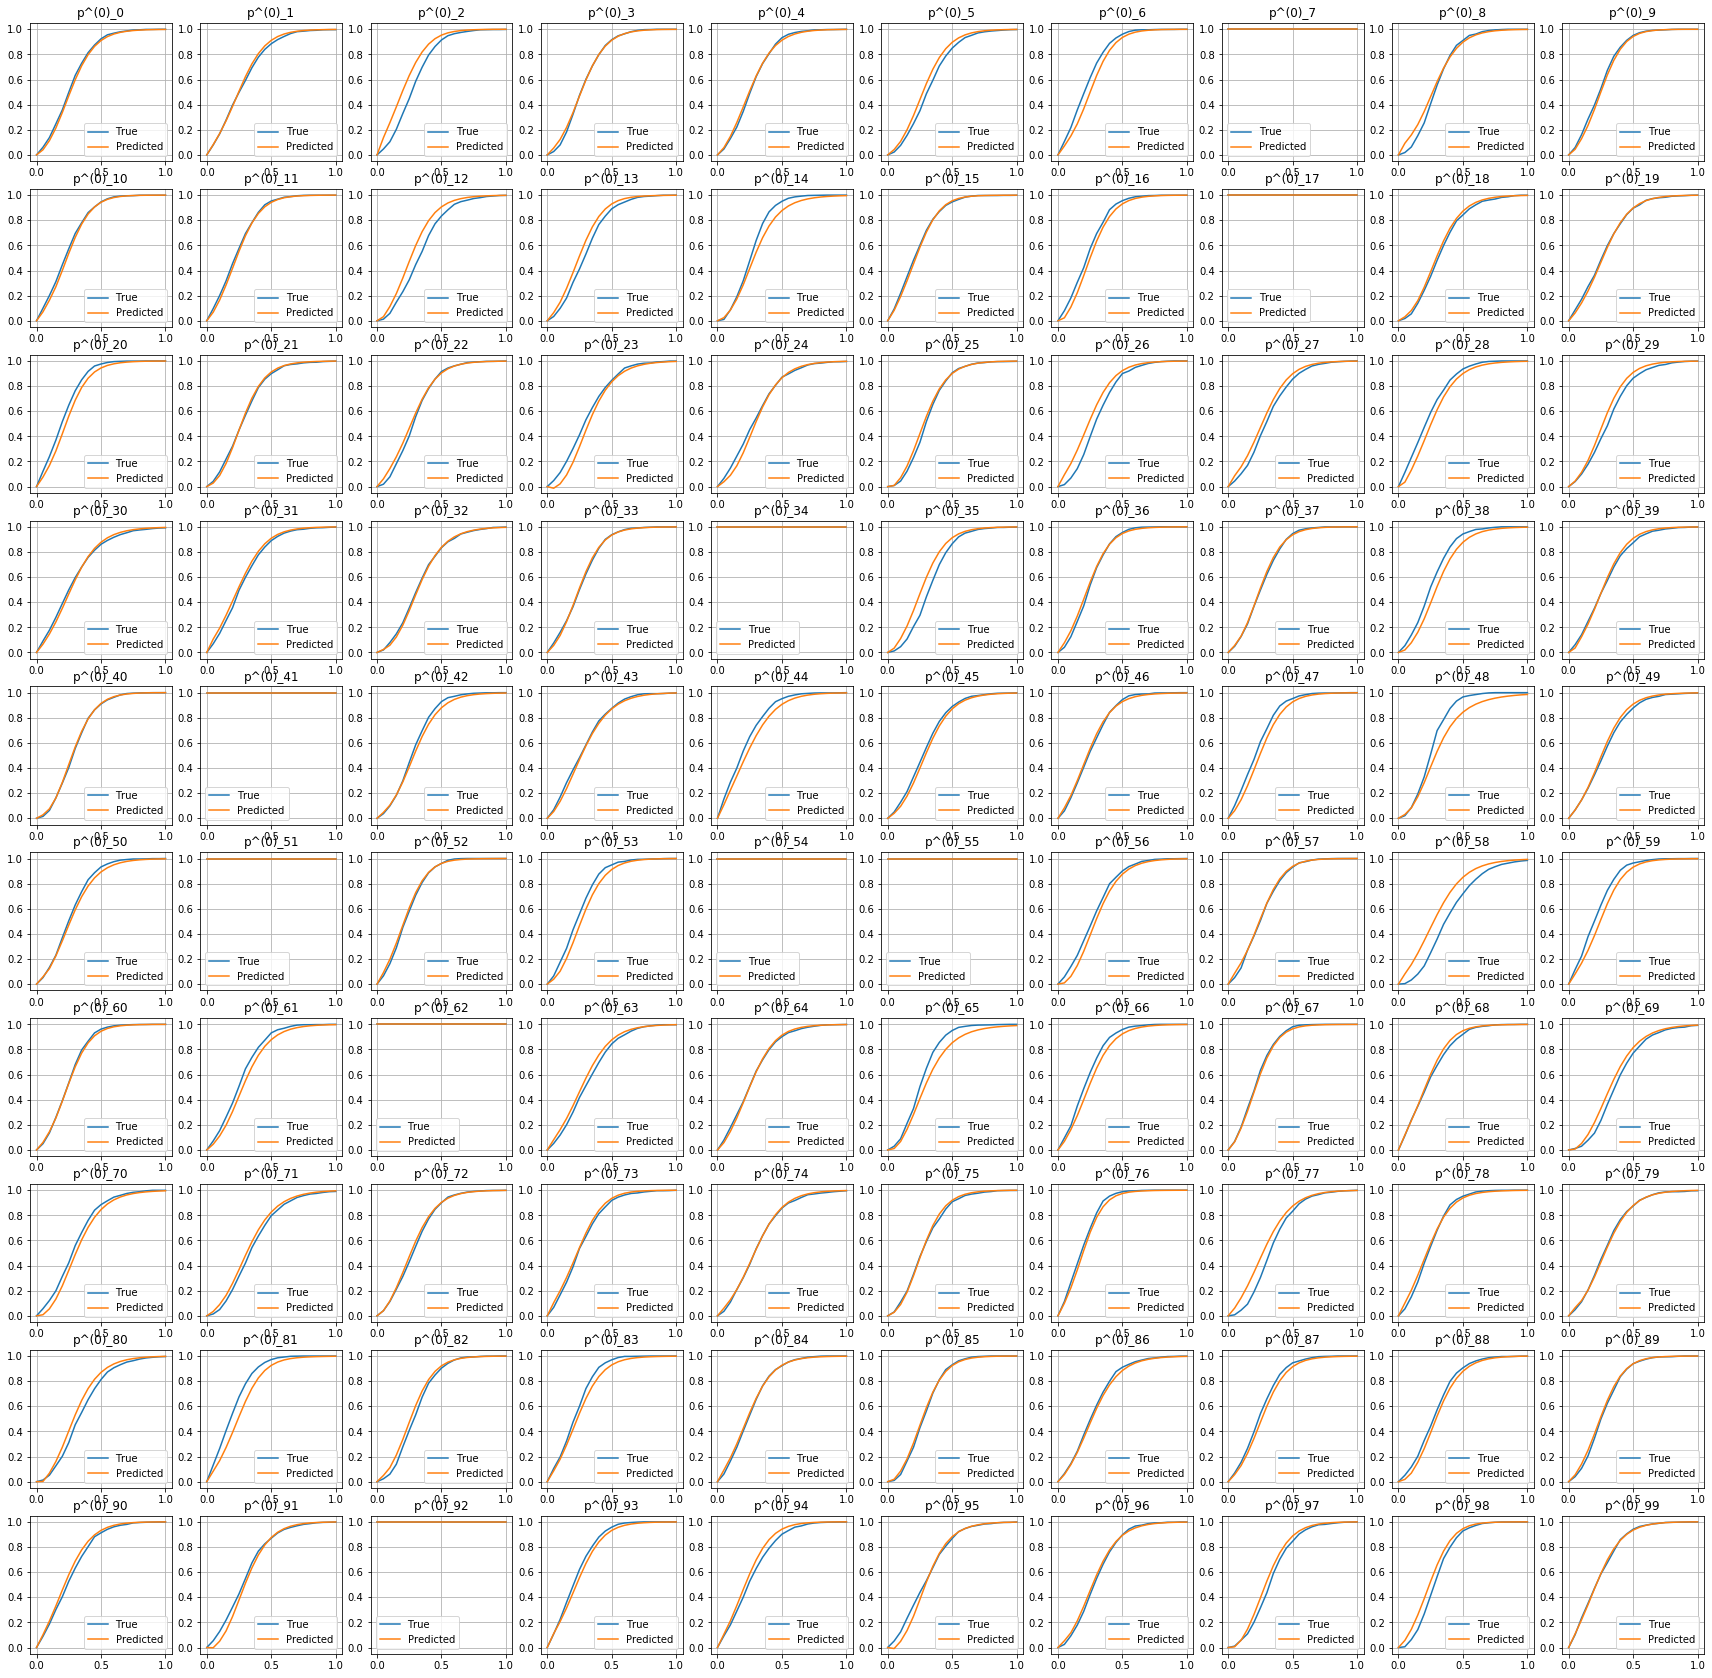

In [32]:
#select an example number from the test set to visually compare 
#the predicted evolution vs the true evolution on each node
compare_curves(dataset_test, example_num=0)

In [0]:
#save the settings of the model
hyperparameters = {'num_lstm_layers':num_lstm_layers, 'lstm_hidden_size':lstm_hidden_size,\
                       'testSetSize':testSetSize, 'num_examples':num_examples,\
                       'num_timesteps':num_timesteps, 'num_nodes':num_nodes,
                        'LR': LR, 'epochs':epochs, 'WeightDecay':WeightDecay, 'Momentum':Momentum }
disease_spread_parameters = [hyperparameters, forward_pass.state_dict()]

torch.save(disease_spread_parameters, 'disease_spread_parameters.pt')